In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',500)
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta

In [39]:
from scipy.stats.mstats import gmean
from scipy import std
import math

## Evelyn's old method

In [92]:
test = pd.read_csv('test_output.csv')
test['date'] = test['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
test['YearMonth_test'] = test['date'].astype(str).apply(lambda x: x[:4] + x[5:7])
test['YearMonth_test'] = test['YearMonth_test'].apply(pd.to_numeric)
test['YearMonth'] = test['date'].astype(str).apply(lambda x: x[:4] + x[5:7])
test = test[['PERMNO','YearMonth','RET']]

In [93]:
test.head()

,PERMNO,YearMonth,RET
0,10030,192908,0.030568
1,10102,192908,0.223731
2,10137,192908,0.260185
3,10145,192908,0.123596
4,10196,192908,0.187726


In [94]:
train = pd.read_csv('train_output.csv')
train = train[['PERMNO','YearMonth','weight','residual_weight']]
train['YearMonth'] = train['YearMonth'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m'))
train['YearMonth'] = train['YearMonth'].apply(lambda x: x + relativedelta(months=1))
train['YearMonth'] = train['YearMonth'].astype(str).apply(lambda x: x[:4] + x[5:7])

In [95]:
train.head()

,PERMNO,YearMonth,weight,residual_weight
0,12386,192908,0.010622,-0.043266
1,10030,192908,-0.002759,0.018422
2,13864,192908,0.005287,0.061555
3,11068,192908,-0.003037,-0.045861
4,10890,192908,-0.005067,-0.035998


In [98]:
combine = pd.merge(test, train, how='inner', on=['YearMonth','PERMNO'])

In [247]:
combine = pd.read_csv('further_test_output.csv')

In [253]:
loser_cob = combine[combine['residual_weight']<0]
loser_cob['res_ret'] = loser_cob['residual_weight'] * loser_cob['RET'] * (-1)
loser_cob = pd.DataFrame(loser_cob.groupby('YearMonth').sum(axis='res_ret')["res_ret"])

/Users/zhikang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [255]:
loser_cob['res_ret'].mean()

0.014672135418317963

In [258]:
winner_cob = combine[combine['residual_weight']>0]
winner_cob['res_ret'] = winner_cob['residual_weight'] * winner_cob['RET'] *(-1)
winner_cob = pd.DataFrame(winner_cob.groupby('YearMonth').sum(axis='res_ret')["res_ret"])

/Users/zhikang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [259]:
winner_cob['res_ret'].mean()

-0.00533893200238549

## Start from here

In [46]:
combine = pd.read_csv('further_test_output.csv')
combine = combine.rename(columns = {"conv_weight": "weight"})
combine['conv_ret'] = combine['RET']*combine['weight']
combine['res_ret'] = combine['RET']*combine['residual_weight']
portfolio_conventional_ret=pd.DataFrame(combine.groupby('YearMonth').sum(axis='conv_ret')["conv_ret"])
portfolio_residual_ret=pd.DataFrame(combine.groupby('YearMonth').sum(axis='res_ret')["res_ret"])
portfolio_conventional_ret = -1*portfolio_conventional_ret
portfolio_residual_ret = -1* portfolio_residual_ret
df = pd.merge(portfolio_conventional_ret, portfolio_residual_ret, how='inner', on=['YearMonth'])

In [66]:
df.head()

,conv_ret,res_ret,cov_ret,red_ret
YearMonth,,,,
192908,-0.026623,-0.001437,0.973377,0.998563
192909,0.016686,0.021901,1.016686,1.021901
192910,0.083404,0.108917,1.083404,1.108917
192911,-0.086365,0.025509,0.913635,1.025509
192912,0.030368,-0.021257,1.030368,0.978743


In [64]:
export_csv = df.to_csv ('ff_3_ret.csv', index = True, header=True)

### 3 factor: 1926——2010

In [81]:
df_2010 = df[df.index < 201101]

In [82]:
graph = df_2010.copy()

In [83]:
graph['cov_ret'] = graph['conv_ret'] + 1
graph['red_ret'] = graph['res_ret'] + 1
graph_output = graph.cumprod()
graph_output['YearMonth'] = graph.index
graph = graph_output
graph['date'] = pd.to_datetime(graph['YearMonth'], format='%Y%m')
graph = graph.drop('YearMonth', 1)

In [84]:
graph_1 = graph[['date','cov_ret']]
graph_1['return type'] = "conventional_return"
graph_2 = graph[['date','red_ret']]
graph_2['return type'] = "residual_return"
graph_1 = graph_1.rename(columns = {'cov_ret':'return'})
graph_2 = graph_2.rename(columns = {'red_ret':'return'})
final_graph = pd.concat([graph_1, graph_2],ignore_index=True)

/Users/zhikang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/zhikang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


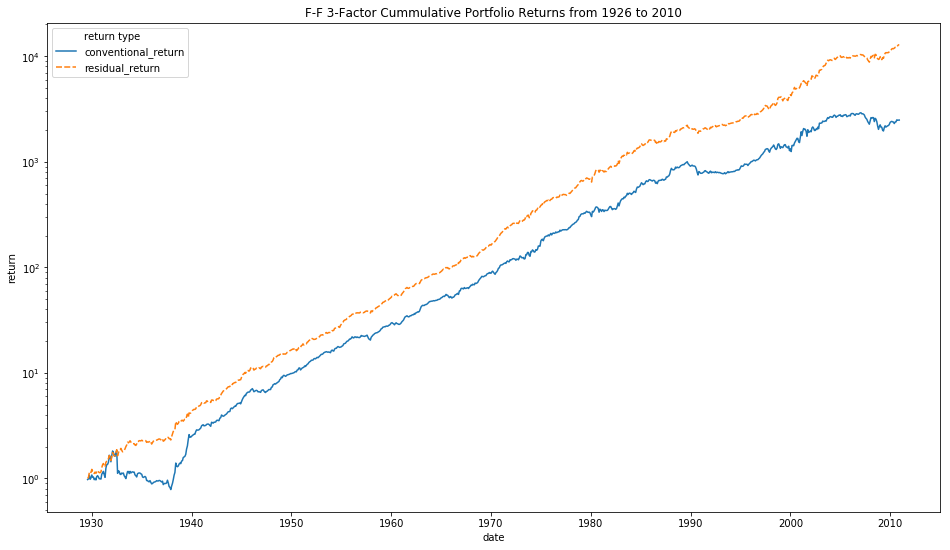

In [86]:
plt.figure(figsize = (16,9))
ax = sns.lineplot(x='date', y="return", hue="return type",  style="return type", data=final_graph)
plt.title('F-F 3-Factor Cummulative Portfolio Returns from 1926 to 2010')
ax.set(yscale="log")
# plt.show()
# plt.ylim=(-1000, 17000)
plt.savefig('3_factor_cum_ret_1926_2010.png')

### FF3: stats from 1926 to 2010

In [87]:
FF_3_port_return = df_2010

In [93]:
FF_3_port_return['cov_ret'] = FF_3_port_return['conv_ret'] + 1
FF_3_port_return['red_ret'] = FF_3_port_return['res_ret'] + 1
FF_3_cov_ret_geomean = gmean(FF_3_port_return.loc[:,'cov_ret'])
FF_3_res_ret_geomean = gmean(FF_3_port_return.loc[:,'red_ret'])
FF_3_ann_cov_ret = FF_3_cov_ret_geomean**12-1
FF_3_ann_res_ret = FF_3_res_ret_geomean**12-1

FF_3_cov_ret_std = std(FF_3_port_return.loc[:,'cov_ret'])
FF_3_res_ret_std = std(FF_3_port_return.loc[:,'red_ret'])
FF_3_ann_cov_std = FF_3_cov_ret_std*math.sqrt(12)
FF_3_ann_res_std = FF_3_res_ret_std*math.sqrt(12)

/Users/zhikang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/zhikang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [94]:
FF_3_cov_ret_geomean

1.0080339168896897

In [95]:
FF_3_res_ret_geomean

1.0097302254360006

### 3 factor: 2010——2019

In [96]:
df_2019 = df[df.index > 201012]

In [97]:
graph = df_2019.copy()

In [98]:
graph['cov_ret'] = graph['conv_ret'] + 1
graph['red_ret'] = graph['res_ret'] + 1
graph_output = graph.cumprod()
graph_output['YearMonth'] = graph.index
graph = graph_output
graph['date'] = pd.to_datetime(graph['YearMonth'], format='%Y%m')
graph = graph.drop('YearMonth', 1)

In [99]:
graph_1 = graph[['date','cov_ret']]
graph_1['return type'] = "conventional_return"
graph_2 = graph[['date','red_ret']]
graph_2['return type'] = "residual_return"
graph_1 = graph_1.rename(columns = {'cov_ret':'return'})
graph_2 = graph_2.rename(columns = {'red_ret':'return'})
final_graph = pd.concat([graph_1, graph_2],ignore_index=True)

/Users/zhikang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/zhikang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


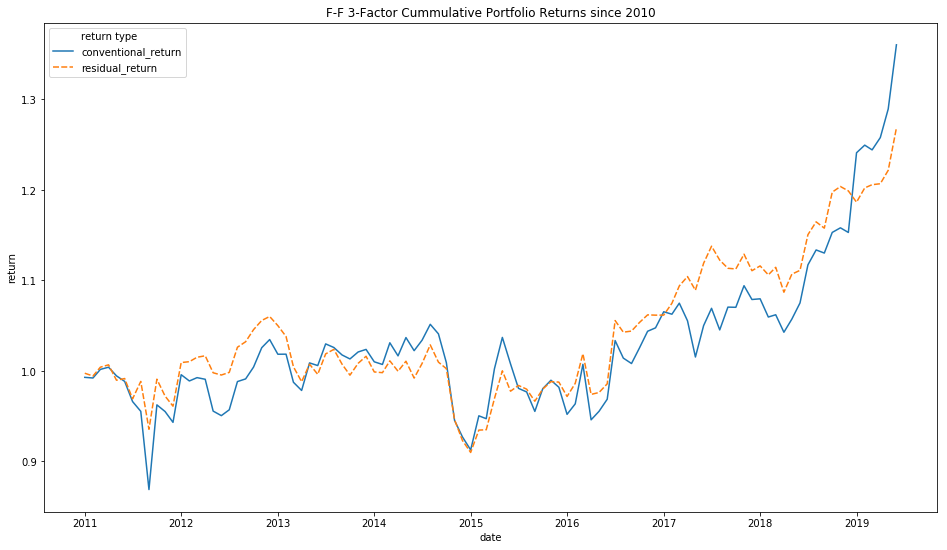

In [105]:
plt.figure(figsize = (16,9))
ax = sns.lineplot(x='date', y="return", hue="return type",  style="return type", data=final_graph)
plt.title('F-F 3-Factor Cummulative Portfolio Returns since 2010')
# ax.set(yscale="log")
# plt.show()
# plt.ylim=(-1000, 17000)
plt.savefig('3_factor_cum_ret_2010_2019.png')

### FF3: stats from 2010 to 2019

In [101]:
FF_3_port_return = df_2019

In [102]:
FF_3_port_return['cov_ret'] = FF_3_port_return['conv_ret'] + 1
FF_3_port_return['red_ret'] = FF_3_port_return['res_ret'] + 1
FF_3_cov_ret_geomean = gmean(FF_3_port_return.loc[:,'cov_ret'])
FF_3_res_ret_geomean = gmean(FF_3_port_return.loc[:,'red_ret'])
FF_3_ann_cov_ret = FF_3_cov_ret_geomean**12-1
FF_3_ann_res_ret = FF_3_res_ret_geomean**12-1

FF_3_cov_ret_std = std(FF_3_port_return.loc[:,'cov_ret'])
FF_3_res_ret_std = std(FF_3_port_return.loc[:,'red_ret'])
FF_3_ann_cov_std = FF_3_cov_ret_std*math.sqrt(12)
FF_3_ann_res_std = FF_3_res_ret_std*math.sqrt(12)

/Users/zhikang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/zhikang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [103]:
FF_3_cov_ret_geomean

1.003021885398517

In [104]:
FF_3_res_ret_geomean

1.0023345431422486

## statistics from 1926 to 2019

In [57]:
FF_3_port_return = df

In [58]:
FF_3_port_return.head()

,conv_ret,res_ret
YearMonth,,
192908,-0.026623,-0.001437
192909,0.016686,0.021901
192910,0.083404,0.108917
192911,-0.086365,0.025509
192912,0.030368,-0.021257


### annualized return

In [59]:
FF_3_port_return['cov_ret'] = FF_3_port_return['conv_ret'] + 1
FF_3_port_return['red_ret'] = FF_3_port_return['res_ret'] + 1
FF_3_cov_ret_geomean = gmean(FF_3_port_return.loc[:,'cov_ret'])
FF_3_res_ret_geomean = gmean(FF_3_port_return.loc[:,'red_ret'])
FF_3_ann_cov_ret = FF_3_cov_ret_geomean**12-1
FF_3_ann_res_ret = FF_3_res_ret_geomean**12-1

In [62]:
FF_3_cov_ret_geomean

1.007559049745476

In [63]:
FF_3_res_ret_geomean

1.0090287678285743

### std

In [ ]:
FF_3_cov_ret_std = std(FF_3_port_return.loc[:,'cov_ret'])
FF_3_res_ret_std = std(FF_3_port_return.loc[:,'red_ret'])
FF_3_ann_cov_std = FF_3_cov_ret_std*math.sqrt(12)
FF_3_ann_res_std = FF_3_res_ret_std*math.sqrt(12)

## 3-factor vs. 5-factor (1966-2019)

In [169]:
combine = pd.read_csv('further_test_output.csv')
combine = combine.rename(columns = {"conv_weight": "weight"})
combine['conv_ret'] = combine['RET']*combine['weight']
combine['res_ret'] = combine['RET']*combine['residual_weight']
portfolio_conventional_ret=pd.DataFrame(combine.groupby('YearMonth').sum(axis='conv_ret')["conv_ret"])
portfolio_residual_ret=pd.DataFrame(combine.groupby('YearMonth').sum(axis='res_ret')["res_ret"])
portfolio_conventional_ret = -1*portfolio_conventional_ret
portfolio_residual_ret = -1* portfolio_residual_ret
df = pd.merge(portfolio_conventional_ret, portfolio_residual_ret, how='inner', on=['YearMonth'])

In [170]:
FF_3_port_return = df[df.index > 196607]

In [172]:
combine = pd.read_csv('5_factor_further_test_output.csv')

In [173]:
combine = combine.rename(columns = {"conv_weight": "weight"})
combine['conv_ret'] = combine['RET']*combine['weight']
combine['res_ret'] = combine['RET']*combine['residual_weight']
portfolio_conventional_ret=pd.DataFrame(combine.groupby('YearMonth').sum(axis='conv_ret')["conv_ret"])
portfolio_residual_ret=pd.DataFrame(combine.groupby('YearMonth').sum(axis='res_ret')["res_ret"])
portfolio_conventional_ret = -1*portfolio_conventional_ret
portfolio_residual_ret = -1* portfolio_residual_ret
FF_5_port_return = pd.merge(portfolio_conventional_ret, portfolio_residual_ret, how='inner', on=['YearMonth'])

In [124]:
export_csv = df.to_csv ('ff_5_ret.csv', index = True, header=True)

In [174]:
FF_5_port_return = FF_5_port_return.rename(columns = {'res_ret': "res_ret_5"})
FF_3_port_return = FF_3_port_return.rename(columns = {'res_ret': "res_ret_3"})
df_all = pd.merge(FF_5_port_return, FF_3_port_return, how='inner', on=['YearMonth'])
df_all = df_all.drop('conv_ret_x', 1)
df_all = df_all.drop('conv_ret_y', 1)

In [175]:
df_all.head()

,res_ret_5,res_ret_3
YearMonth,,
196608,0.012647,0.014430
196609,0.039937,0.042682
196610,-0.010997,-0.023956
196611,0.025132,0.033064
196612,0.006454,0.003750


In [176]:
graph = df_all.copy()
graph['res_ret_5'] = graph['res_ret_5'] + 1
graph['res_ret_3'] = graph['res_ret_3'] + 1
graph_output = graph.cumprod()
graph_output['YearMonth'] = graph.index

In [177]:
graph = graph_output.copy()
graph['date'] = pd.to_datetime(graph['YearMonth'], format='%Y%m')
graph = graph.drop('YearMonth', 1)

In [178]:
graph_1 = graph[['date','res_ret_3']]
graph_1['model type'] = "FF3"
graph_2 = graph[['date','res_ret_5']]
graph_2['model type'] = "FF5"

In [181]:
graph_1 = graph_1.rename(columns = {'res_ret_3':'return'})
graph_2 = graph_2.rename(columns = {'res_ret_5':'return'})

In [182]:
final_graph = pd.concat([graph_1, graph_2],ignore_index=True)

In [214]:
final_graph.head()

,date,return,model type
0,1966-08-01,1.014430,FF3
1,1966-09-01,1.057728,FF3
2,1966-10-01,1.032389,FF3
3,1966-11-01,1.066524,FF3
4,1966-12-01,1.070523,FF3


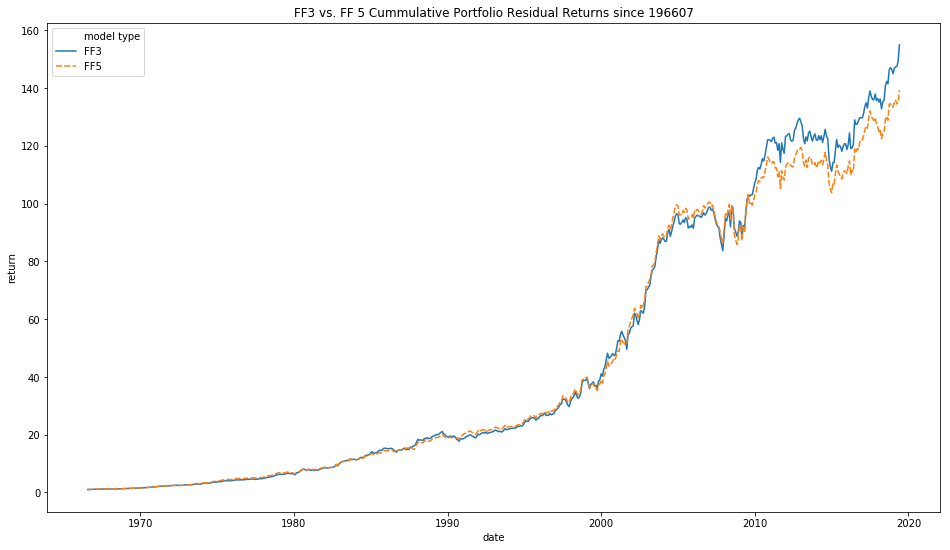

In [186]:
plt.figure(figsize = (16,9))
ax = sns.lineplot(x='date', y="return", hue="model type",  style="model type", data=final_graph)
plt.title('FF3 vs. FF 5 Cummulative Portfolio Residual Returns since 196607')
# ax.set(yscale="log")
# plt.ylim=(-1000, 17000)
plt.savefig('FF3_vs_FF5.png')

In [217]:
FF_3_port_return.head()

,conv_ret,res_ret_3,cov_ret,red_ret
YearMonth,,,,
196608,0.015827,0.014430,1.015827,1.014430
196609,0.011714,0.042682,1.011714,1.042682
196610,-0.023093,-0.023956,0.976907,0.976044
196611,0.077091,0.033064,1.077091,1.033064
196612,0.002627,0.003750,1.002627,1.003750


In [218]:
FF_3_port_return['cov_ret'] = FF_3_port_return['conv_ret'] + 1
FF_3_port_return['red_ret'] = FF_3_port_return['res_ret_3'] + 1

In [219]:
FF_3_cov_ret_geomean = gmean(FF_3_port_return.loc[:,'cov_ret'])
FF_3_res_ret_geomean = gmean(FF_3_port_return.loc[:,'red_ret'])
FF_3_ann_cov_ret = FF_3_cov_ret_geomean**12-1
FF_3_ann_res_ret = FF_3_res_ret_geomean**12-1

In [220]:
FF_3_ann_cov_ret

0.08089066872600914

In [221]:
FF_3_ann_res_ret

0.09999362545645973

In [222]:
FF_3_cov_ret_std = std(FF_3_port_return.loc[:,'cov_ret'])
FF_3_res_ret_std = std(FF_3_port_return.loc[:,'red_ret'])
FF_3_ann_cov_std = FF_3_cov_ret_std*math.sqrt(12)
FF_3_ann_res_std = FF_3_res_ret_std*math.sqrt(12)

In [223]:
FF_3_ann_cov_std

0.10954741068075156

In [224]:
FF_5 = pd.read_csv('F-F_5.csv')
gmean(FF_5_port_return.loc[:,'cov_ret'])
Rf = FF_5['RF']/100
Rf = gmean(Rf)
ann_rf = (1+Rf)**12-1
FF_3_cov_sharpe = (FF_3_ann_cov_ret - ann_rf)/FF_3_ann_cov_std
FF_3_res_sharpe = (FF_3_ann_res_ret - ann_rf)/FF_3_ann_res_std

In [225]:
FF_3_cov_sharpe

0.738407856683575

In [226]:
FF_3_res_sharpe

1.2015425780885955

In [227]:
FF_5_port_return.head()

,conv_ret,res_ret_5,cov_ret,red_ret
YearMonth,,,,
196608,0.015827,0.012647,1.015827,1.012647
196609,0.011714,0.039937,1.011714,1.039937
196610,-0.023093,-0.010997,0.976907,0.989003
196611,0.077091,0.025132,1.077091,1.025132
196612,0.002627,0.006454,1.002627,1.006454


In [228]:
FF_5_port_return['cov_ret'] = FF_5_port_return['conv_ret'] + 1
FF_5_port_return['red_ret'] = FF_5_port_return['res_ret_5'] + 1
FF_5_cov_ret_geomean = gmean(FF_5_port_return.loc[:,'cov_ret'])
FF_5_res_ret_geomean = gmean(FF_5_port_return.loc[:,'red_ret'])
FF_5_ann_cov_ret = FF_5_cov_ret_geomean**12-1
FF_5_ann_res_ret = FF_5_res_ret_geomean**12-1

In [229]:
FF_5_cov_ret_std = std(FF_5_port_return.loc[:,'cov_ret'])
FF_5_res_ret_std = std(FF_5_port_return.loc[:,'red_ret'])
FF_5_ann_cov_std = FF_5_cov_ret_std*math.sqrt(12)
FF_5_ann_res_std = FF_5_res_ret_std*math.sqrt(12)

In [230]:
FF_5_cov_sharpe = (FF_5_ann_cov_ret - ann_rf)/FF_5_ann_cov_std
FF_5_res_sharpe = (FF_5_ann_res_ret - ann_rf)/FF_5_ann_res_std

In [236]:
FF_5_ann_res_ret

0.0977764335638478

In [237]:
FF_5_ann_cov_ret

0.08089066872600914

In [238]:
FF_5_cov_sharpe

0.7384078566835749

In [239]:
FF_5_res_sharpe

1.2161251180333588

In [240]:
d = {'conventional': [FF_3_cov_sharpe, FF_5_cov_sharpe,FF_3_ann_cov_ret, FF_5_ann_cov_ret,FF_3_ann_cov_std,FF_5_ann_cov_std], 
     'residual': [FF_3_res_sharpe, FF_5_res_sharpe,FF_3_ann_res_ret,FF_5_ann_res_ret,FF_3_ann_res_std,FF_5_ann_res_std]}

In [241]:
sharpe_summary = pd.DataFrame(d)

In [245]:
sharpe_summary.index = ['FF3 shapre','FF5 sharpe','FF3 annualized return',
                        'FF5 annualized return','FF3 annualized std','FF5 annualized std']

In [246]:
sharpe_summary

,conventional,residual
FF3 shapre,0.738408,1.201543
FF5 sharpe,0.738408,1.216125
FF3 annualized return,0.080891,0.099994
FF5 annualized return,0.080891,0.097776
FF3 annualized std,0.109547,0.083221
FF5 annualized std,0.109547,0.080400
